# fasttext

In [3]:
import pandas as pd
import duckdb
conn = duckdb.connect('/srv/data/greek/grela.duckdb', read_only=True)

In [25]:
query = '''
SELECT t.*, w.*
FROM tokens t
JOIN works w ON t.grela_id = w.grela_id
WHERE w.lagt_provenience IN ('christian', 'pagan')
  AND t.pos IN ('n', 'v', 'a')
  AND (
    (w.not_before > 0 AND w.not_before < 600)
    OR (w.not_after > 0 AND w.not_after < 600)
  )
'''
df = conn.execute(query).fetchdf()
df

,sentence_id,grela_id,token_text,lemma,pos,char_start,char_end,token_id,grela_source,grela_id_1,...,noscemus_genre,noscemus_discipline,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,token_count
0,lagt_tlg2023.tlg006_1796,lagt_tlg2023.tlg006,πάντας,πᾶς,a,107,113,143512724,lagt,lagt_tlg2023.tlg006,...,None,None,None,NaN,None,None,NaN,NaN,263.0,45847
1,lagt_tlg2023.tlg006_1796,lagt_tlg2023.tlg006,ἁπλουστέρους,ἁπλόος,a,124,136,143512727,lagt,lagt_tlg2023.tlg006,...,None,None,None,NaN,None,None,NaN,NaN,263.0,45847
2,lagt_tlg2023.tlg006_1796,lagt_tlg2023.tlg006,νέους,νέος,a,141,146,143512729,lagt,lagt_tlg2023.tlg006,...,None,None,None,NaN,None,None,NaN,NaN,263.0,45847
3,lagt_tlg2023.tlg006_1796,lagt_tlg2023.tlg006,ἐπιτηδειοτέρους,ἐπιτήδειος,a,147,162,143512730,lagt,lagt_tlg2023.tlg006,...,None,None,None,NaN,None,None,NaN,NaN,263.0,45847
4,lagt_tlg2023.tlg006_1796,lagt_tlg2023.tlg006,δηλοῖ,δηλόω,v,164,169,143512732,lagt,lagt_tlg2023.tlg006,...,None,None,None,NaN,None,None,NaN,NaN,263.0,45847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10008973,lagt_tlg2200.tlg00551_250,lagt_tlg2200.tlg00551,ἰσχύος,ἰσχύς,n,24,30,176894717,lagt,lagt_tlg2200.tlg00551,...,None,None,None,NaN,None,None,NaN,NaN,387.0,1888
10008974,lagt_tlg2200.tlg00551_250,lagt_tlg2200.tlg00551,περίεστιν,περίεστις,v,31,40,176894718,lagt,lagt_tlg2200.tlg00551,...,None,None,None,NaN,None,None,NaN,NaN,387.0,1888
10008975,lagt_tlg2200.tlg00551_250,lagt_tlg2200.tlg00551,ἀμνηστίαν,ἀμνηστία,n,44,53,176894720,lagt,lagt_tlg2200.tlg00551,...,None,None,None,NaN,None,None,NaN,NaN,387.0,1888
10008976,lagt_tlg2200.tlg00551_250,lagt_tlg2200.tlg00551,πεπωκόσιν,πεπωκό,v,59,68,176894722,lagt,lagt_tlg2200.tlg00551,...,None,None,None,NaN,None,None,NaN,NaN,387.0,1888


0-300
300-600

In [ ]:
grouped = (
    df.groupby('sentence_id')
    .agg({
        'lemma': lambda x: ' '.join(x),          # Join lemmas into a sentence
        'token_id': list,                       # Collect token_ids into a list
        'title': 'first',                        # Keep the first title (should be the same for the sentence)
        'author': 'first',
        'lagt_provenience': 'first',
        'not_before': 'first',                        # Keep the first title (should be the same for the sentence)
        'not_after': 'first',
    })
    .rename(columns={'lemma': 'lamma_sentence', 'token_id': 'token_ids'})
    .reset_index()
)
grouped.to_pickle('../data/large-data/grouped_df.pkl')

In [4]:
grouped = pd.read_pickle('../data/large-data/grouped_df.pkl')

In [7]:
grouped.head(10)

,sentence_id,lamma_sentence,token_ids,title,author,lagt_provenience,not_before,not_after
0,lagt_ogl0001.ogl001_4,πινυτός ἀντιγράφω,"[157411875, 157411876]",De Epistola Pinyti ad Dionysium,Pinytus,christian,101.0,200.0
1,lagt_ogl0001.ogl001_5,θαυμάζω ἀποδέχω διονύσιος,"[157411878, 157411881, 157411883]",De Epistola Pinyti ad Dionysium,Pinytus,christian,101.0,200.0
2,lagt_ogl0001.ogl001_6,ἀντιπαρακαλέω στεῤῥοτέρας μεταδίδωμι τροφή,"[157411885, 157411887, 157411890, 157411891]",De Epistola Pinyti ad Dionysium,Pinytus,christian,101.0,200.0
3,lagt_ogl0001.ogl001_7,τελειοτέρω γράμμα λαός ὑποθρέψαντα διατέλος γα...,"[157411893, 157411894, 157411899, 157411900, 1...",De Epistola Pinyti ad Dionysium,Pinytus,christian,101.0,200.0
4,lagt_ogl0001.ogl001_8,ἐπιστολή πινυτός πίστις ὀρθοδοξία φροντίς ὑπήκ...,"[157411918, 157411922, 157411925, 157411926, 1...",De Epistola Pinyti ad Dionysium,Pinytus,christian,101.0,200.0
5,lagt_ogl0001.ogl001_9,ἀκριβεστάτης ἀναδείκνυται εἰκών,"[157411948, 157411949, 157411950]",De Epistola Pinyti ad Dionysium,Pinytus,christian,101.0,200.0
6,lagt_tlg0004.tlg001_0,φιλοσοφία ἔργον ἔνιοι φημί βάρβαρος ἄρχω,"[174017357, 174017358, 174017359, 174017360, 1...",Βίοι καὶ γνῶμαι τῶν ἐν φιλοσοφίᾳ εὐδοκιμησάντων,Diogenes Laertius,pagan,222.0,235.0
7,lagt_tlg0004.tlg001_1,γίγνομαι Πέρσης Μάγος Βαβυλώνιος Ἀσσύριος Χαλδ...,"[174017365, 174017369, 174017370, 174017374, 1...",Βίοι καὶ γνῶμαι τῶν ἐν φιλοσοφίᾳ εὐδοκιμησάντων,Diogenes Laertius,pagan,222.0,235.0
8,lagt_tlg0004.tlg001_10,Εὔμολπος παῖς φημί ποιέω Θεογονία Σφαῖρα πρῶτος,"[174017591, 174017592, 174017593, 174017595, 1...",Βίοι καὶ γνῶμαι τῶν ἐν φιλοσοφίᾳ εὐδοκιμησάντων,Diogenes Laertius,pagan,222.0,235.0
9,lagt_tlg0004.tlg001_100,φιλόσοφος γίγνομαι δογματικός ἐφεκτικός,"[174018916, 174018919, 174018920, 174018924]",Βίοι καὶ γνῶμαι τῶν ἐν φιλοσοφίᾳ εὐδοκιμησάντων,Diogenes Laertius,pagan,222.0,235.0


In [5]:
# Split by 'lagt_provenience'
grouped_christian = grouped[grouped['lagt_provenience'] == 'christian']
grouped_pagan = grouped[grouped['lagt_provenience'] == 'pagan']

christian_0_300 = grouped_christian[
    (grouped_christian['not_before'] >= 0) & (grouped_christian['not_after'] <= 300)
]
christian_300_600 = grouped_christian[
    (grouped_christian['not_before'] >= 300) & (grouped_christian['not_after'] <= 600)
]

pagan_0_300 = grouped_pagan[
    (grouped_pagan['not_before'] >= 0) & (grouped_pagan['not_after'] <= 300)
]
pagan_300_600 = grouped_pagan[
    (grouped_pagan['not_before'] >= 300) & (grouped_pagan['not_after'] <= 600)
]

In [ ]:
from nltk.probability import FreqDist

fdist1 = FreqDist(word for sent in christian_0_300['lamma_sentence'] for word in sent.split())
fdist2 = FreqDist(word for sent in christian_300_600['lamma_sentence'] for word in sent.split())
fdist3 = FreqDist(word for sent in pagan_0_300['lamma_sentence'] for word in sent.split())
fdist4 = FreqDist(word for sent in pagan_300_600['lamma_sentence'] for word in sent.split())

# Find words that appear >=10 times in all subcorpora
common_words = set(
    word for word in fdist1 if fdist1[word] >= 10
) & set(
    word for word in fdist2 if fdist2[word] >= 10
) & set(
    word for word in fdist3 if fdist3[word] >= 10
) & set(
    word for word in fdist4 if fdist4[word] >= 10
)

# Filter each subcorpus to only keep those words
words1 = {word: fdist1[word] for word in common_words}
words2 = {word: fdist2[word] for word in common_words}
words3 = {word: fdist3[word] for word in common_words}
words4 = {word: fdist4[word] for word in common_words}

In [7]:
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec
from gensim.utils import RULE_KEEP, RULE_DISCARD, RULE_DEFAULT

class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
    def on_epoch_begin(self, model):
        print(f"Epoch #{self.epoch} start")
    def on_epoch_end(self, model):
        print(f"Epoch #{self.epoch} end")
        self.epoch += 1

def train_fasttext_on_subcorpus(sentences, model_path):
    #sentences = [s.split() for s in sentences]
    model = FastText(
        vector_size=100,
        window=5,
        min_count=1,
        sg=1,
        workers=16,
    )
    model.build_vocab_from_freq(word_freq=sentences)
    model.train(
        corpus_iterable=sentences,
        total_examples=len(sentences),
        epochs=20,
        callbacks=[EpochLogger()]
    )
    model.save(model_path)
    return model


In [9]:
# Example usage for each subcorpus:
christian_0_300_model = train_fasttext_on_subcorpus(
    words1, "../data/large-data/fasttext_christian_0_300.model"
)
christian_300_600_model = train_fasttext_on_subcorpus(
    words2, "../data/large-data/fasttext_christian_300_600.model"
)
pagan_0_300_model = train_fasttext_on_subcorpus(
    words3, "../data/large-data/fasttext_pagan_0_300.model"
)
pagan_300_600_model = train_fasttext_on_subcorpus(
    words4, "../data/large-data/fasttext_pagan_300_600.model"
)

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end
Epoch #10 start
Epoch #10 end
Epoch #11 start
Epoch #11 end
Epoch #12 start
Epoch #12 end
Epoch #13 start
Epoch #13 end
Epoch #14 start
Epoch #14 end
Epoch #15 start
Epoch #15 end
Epoch #16 start
Epoch #16 end
Epoch #17 start
Epoch #17 end
Epoch #18 start
Epoch #18 end
Epoch #19 start
Epoch #19 end
Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end
Epoch #10 start
Epoch #10 end
Epoch #11 start
Epoch #11 end
Epoch #12 start
Epoch #12 end
Epoch #13 start
Epoch #13 end
Epoch #14 start
Epoc

In [1]:
from gensim.models import FastText

# Load every FastText model for each subcorpus into a variable
christian_0_300_model = FastText.load("../data/large-data/fasttext_christian_0_300.model")
christian_300_600_model = FastText.load("../data/large-data/fasttext_christian_300_600.model")
pagan_0_300_model = FastText.load("../data/large-data/fasttext_pagan_0_300.model")
pagan_300_600_model = FastText.load("../data/large-data/fasttext_pagan_300_600.model")

In [10]:
%%time
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

models = [
    (christian_0_300_model, "christian_0_300", 0),
    (christian_300_600_model, "christian_300_600", 1),
    (pagan_0_300_model, "pagan_0_300", 2),
    (pagan_300_600_model, "pagan_300_600", 3),
]

dfs = []
for model, label, z in models:
    vocab = list(model.wv.index_to_key)
    vecs = [model.wv[w] for w in vocab]
    tsne = TSNE(n_components=2, random_state=42, verbose=1)
    tsne_result = tsne.fit_transform(np.array(vecs))
    df = pd.DataFrame({
        "word": vocab,
        "x": tsne_result[:, 0],
        "y": tsne_result[:, 1],
        "z": z,
        "subcorpus": label
    })
    dfs.append(df)

df_plot = pd.concat(dfs, ignore_index=True)
df_plot.to_pickle("../data/large-data/df_plot.pkl")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3561 samples in 0.001s...
[t-SNE] Computed neighbors for 3561 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3561
[t-SNE] Computed conditional probabilities for sample 2000 / 3561
[t-SNE] Computed conditional probabilities for sample 3000 / 3561
[t-SNE] Computed conditional probabilities for sample 3561 / 3561
[t-SNE] Mean sigma: 0.003331
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.659798
[t-SNE] KL divergence after 1000 iterations: 3.194238
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3561 samples in 0.000s...
[t-SNE] Computed neighbors for 3561 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3561
[t-SNE] Computed conditional probabilities for sample 2000 / 3561
[t-SNE] Computed conditional probabilities for sample 3000 / 3561
[t-SNE] Computed conditional probabilities for sample 3561 / 3561
[t-SNE] Mean sigma: 0.003326


In [3]:
df_plot = pd.read_pickle("../data/large-data/df_plot.pkl")

In [11]:
%%time
# Precompute nearest neighbors for all words in all subcorpora and save to pickle
from collections import defaultdict

neighbors_dict = defaultdict(dict)
model_map = {
    "christian_0_300": christian_0_300_model,
    "christian_300_600": christian_300_600_model,
    "pagan_0_300": pagan_0_300_model,
    "pagan_300_600": pagan_300_600_model,
}
N_NEIGHBORS = 30

for subcorpus, model in model_map.items():
    for word in model.wv.index_to_key:
        try:
            neighbors = model.wv.most_similar(word, topn=N_NEIGHBORS)  # returns list of (word, similarity)
        except KeyError:
            neighbors = []
        neighbors_dict[subcorpus][word] = neighbors

import pickle
with open("../data/large-data/word_neighbors.pkl", "wb") as f:
    pickle.dump(dict(neighbors_dict), f)

CPU times: user 12.3 s, sys: 41.1 s, total: 53.4 s
Wall time: 1.68 s


# PMI

In [1]:
#zkusit ppmi skrz scikit a tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

grouped = pd.read_pickle('../data/large-data/grouped_df.pkl')

In [2]:
# Split by 'lagt_provenience'
grouped_christian = grouped[grouped['lagt_provenience'] == 'christian']
grouped_pagan = grouped[grouped['lagt_provenience'] == 'pagan']

christian_0_300 = grouped_christian[
    (grouped_christian['not_before'] >= 0) & (grouped_christian['not_after'] <= 300)
]
christian_300_600 = grouped_christian[
    (grouped_christian['not_before'] >= 300) & (grouped_christian['not_after'] <= 600)
]

pagan_0_300 = grouped_pagan[
    (grouped_pagan['not_before'] >= 0) & (grouped_pagan['not_after'] <= 300)
]
pagan_300_600 = grouped_pagan[
    (grouped_pagan['not_before'] >= 300) & (grouped_pagan['not_after'] <= 600)
]

In [54]:
from nltk.probability import FreqDist

# Find most frequent words (lowercased)
fdist1 = FreqDist(word.lower() for sent in christian_0_300['lamma_sentence'] for word in sent.split())
fdist2 = FreqDist(word.lower() for sent in christian_300_600['lamma_sentence'] for word in sent.split())
fdist3 = FreqDist(word.lower() for sent in pagan_0_300['lamma_sentence'] for word in sent.split())
fdist4 = FreqDist(word.lower() for sent in pagan_300_600['lamma_sentence'] for word in sent.split())

# Find words that appear >=10 times in all subcorpora
vocab = set(
    word for word in fdist1 if fdist1[word] >= 10
) & set(
    word for word in fdist2 if fdist2[word] >= 10
) & set(
    word for word in fdist3 if fdist3[word] >= 10
) & set(
    word for word in fdist4 if fdist4[word] >= 10
)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf(sentences):
    vectorizer = TfidfVectorizer(
        #min_df=10,
        #max_features=1000,
        vocabulary=vocab, #use common vocab
    )
    tfidf_matrix = vectorizer.fit_transform(sentences)
    feature_names = vectorizer.get_feature_names_out()
    return [tfidf_matrix, feature_names]

In [56]:
tfidf_christian_0_300 = compute_tfidf(christian_0_300['lamma_sentence'])
tfidf_christian_300_600 = compute_tfidf(christian_300_600['lamma_sentence'])
tfidf_pagan_0_300 = compute_tfidf(pagan_0_300['lamma_sentence'])
tfidf_pagan_300_600 = compute_tfidf(pagan_300_600['lamma_sentence'])

In [34]:
import numpy as np
from itertools import combinations
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def pmi_pair(i, j, top_words, top_indices, col_sums, tfidf_matrix):
    w1, w2 = top_words[i], top_words[j]
    idx1, idx2 = top_indices[i], top_indices[j]
    tfidf_word1 = col_sums[idx1]
    tfidf_word2 = col_sums[idx2]
    rows_with_word1 = tfidf_matrix[:, idx1].nonzero()[0]
    rows_with_word2 = tfidf_matrix[:, idx2].nonzero()[0]
    rows_both = np.intersect1d(rows_with_word1, rows_with_word2)
    joint_tfidf = tfidf_matrix[rows_both, idx1].sum() + tfidf_matrix[rows_both, idx2].sum()
    if joint_tfidf > 0:
        pmi = np.log(joint_tfidf / (tfidf_word1 * tfidf_word2))
        return (w1, w2, pmi)
    return None

def compute_pmi(tfidf_data, top_n=None, max_workers=24):
    """
    Compute weighted PMI for all pairs of words using concurrent.futures.
    tfidf_data: [tfidf_matrix, feature_names]
    top_n: if set, only use top_n words by column sum; else use all words
    max_workers: number of parallel threads
    Returns a list of (word1, word2, pmi).
    """
    tfidf_matrix, feature_names = tfidf_data
    col_sums = np.array(tfidf_matrix.sum(axis=0)).flatten()
    if top_n is not None:
        top_indices = np.argsort(col_sums)[-top_n:]
    else:
        top_indices = np.arange(len(feature_names))
    top_words = feature_names[top_indices]
    pairs = list(combinations(range(len(top_words)), 2))
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(pmi_pair, i, j, top_words, top_indices, col_sums, tfidf_matrix)
            for i, j in pairs
        ]
        for f in tqdm(as_completed(futures), total=len(futures)):
            r = f.result()
            if r is not None:
                results.append(r)
    return results

# Usage:
# pmi_results = compute_pmi(tfidf_christian_0_300, top_n=1000, max_workers=32)

In [ ]:
pmi_results = compute_pmi(tfidf_christian_0_300)
import pickle
with open("../data/large-data/pmi_christian_0_300.pkl", "wb") as f:
    pickle.dump(pmi_results, f)

# just for testing purposes. real run of pmi calculation was done in ./scripts/pmi.py

100%|██████████| 6317235/6317235 [1:20:44<00:00, 1304.10it/s]


In [38]:
df = pd.DataFrame(pmi_results)
df

,0,1,2
0,αβγ,ἄλλος,-11.207420
1,αβγ,ἄλφα,-8.004120
2,αβγ,ἰησοῦς,-12.401045
3,αβγ,κέρας,-9.044090
4,αβγ,κάλλος,-10.739476
...,...,...,...
743639,ῥητός,ῥῆμα,-11.724879
743640,ῥωμαῖος,ῥώμη,-7.657141
743641,ῥωμαῖος,ῥῆμα,-10.172914
743642,ῥώμη,ῥώννυμι,-8.222615


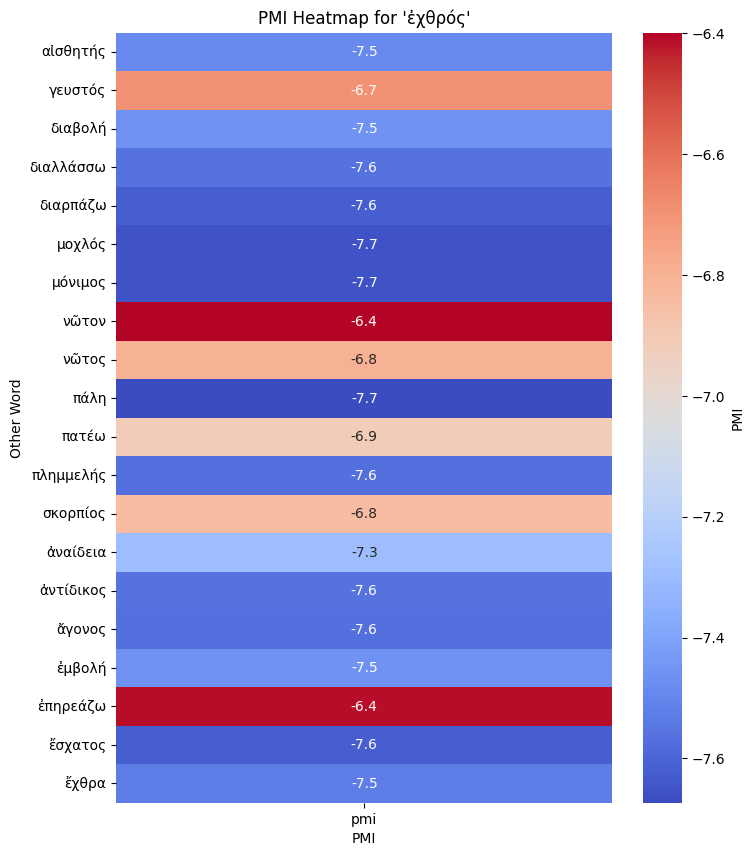

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pmi_heatmap(df, selected_word='ἐχθρός', top_n=20):
    # Filter for pairs containing the selected word
    mask = (df["word1"] == selected_word) | (df["word2"] == selected_word)
    sub = df[mask].copy()
    # Get the other word in each pair
    sub["other"] = sub.apply(lambda row: row["word2"] if row["word1"] == selected_word else row["word1"], axis=1)
    # Sort by PMI and select top_n
    sub = sub.sort_values("pmi", ascending=False).head(top_n)
    # Prepare for heatmap
    heatmap_data = sub.pivot_table(index=["other"], values="pmi")
    plt.figure(figsize=(8, max(4, top_n//2)))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'PMI'})
    plt.title(f"PMI Heatmap for '{selected_word}'")
    plt.ylabel("Other Word")
    plt.xlabel("PMI")
    plt.show()


plot_pmi_heatmap(df)

# text to label for zdenka
Zjeveni = lagt_tlg0031.tlg027
Matous = lagt_tlg0031.tlg001

In [ ]:
query = '''
SELECT t.sentence_id, w.*, s.text
FROM tokens t
JOIN works w ON t.grela_id = w.grela_id
JOIN sentences s ON t.sentence_id = s.sentence_id
WHERE w.lagt_provenience IN ('christian', 'pagan')
  AND t.lemma IN ('ἐχθρός')
  AND (
    (w.not_before > 0 AND w.not_before < 600)
    OR (w.not_after > 0 AND w.not_after < 600)
  )
'''
df = conn.execute(query).fetchdf()
df

,sentence_id,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,...,noscemus_discipline,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,token_count,text
0,lagt_tlg0545.tlg003_92,lagt,lagt_tlg0545.tlg003,Aelian,ἐκ τῶν Αἰλιανοῦ ἀγροικικῶν ἐπιστολῶν,175.0,235.0,['Sophistae'],[],pagan,...,None,None,NaN,None,None,NaN,NaN,186.0,2455,τί γὰρ παθὼν ῥυθμίζεις με καὶ πρᾶον ἀποφῆναι γ...
1,lagt_tlg2200.tlg00427_48,lagt,lagt_tlg2200.tlg00427,Libanius,Oratio 27,385.0,385.0,['Rhetorici' 'Sophistae'],[],pagan,...,None,None,NaN,None,None,NaN,NaN,385.0,5267,οὐδέν οὖν ἕτερον λέγεις ἤ ὅτι φιλοῦσι τούς πον...
2,lagt_tlg0031.tlg014_29,lagt,lagt_tlg0031.tlg014,Pauline literature,New Testament - 2 Thessalonians,80.0,115.0,[],[],christian,...,None,None,NaN,None,None,NaN,NaN,85.0,941,"καὶ μὴ ὡς ἐχθρὸν ἡγεῖσθε, ἀλλὰ νουθετεῖτε ὡς ἀ..."
3,lagt_tlg0007.tlg070_4,lagt,lagt_tlg0007.tlg070,Plutarch,Πῶς ἄν τις διακρίνειε τὸν κόλακα τοῦ φίλου,96.0,120.0,['Biographi' 'Philosophici/-ae'],[],pagan,...,None,None,NaN,None,None,NaN,NaN,104.0,13729,"εἰ δὲ δὴ θεῖον ἡ ἀλήθεια καὶ "" πάντων μὲν ἀγαθ..."
4,lagt_tlg0007.tlg070_30,lagt,lagt_tlg0007.tlg070,Plutarch,Πῶς ἄν τις διακρίνειε τὸν κόλακα τοῦ φίλου,96.0,120.0,['Biographi' 'Philosophici/-ae'],[],pagan,...,None,None,NaN,None,None,NaN,NaN,104.0,13729,"ἡμεῖς δέ, εἰ μηδαμῆ μηδαμῶς ἐπαινοῦμεν τὸ "" ἐρ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461,lagt_tlg0007.tlg027_134,lagt,lagt_tlg0007.tlg027,Plutarch,Philopoemen,68.0,120.0,['Biographi' 'Philosophici/-ae'],[],pagan,...,None,None,NaN,None,None,NaN,NaN,87.0,6386,"ἦν μὲν γὰρ ἐστεφανωμένους ἰδεῖν, ἦν δὲ τοὺς αὐ..."
3462,lagt_tlg0007.tlg035_60,lagt,lagt_tlg0007.tlg035,Plutarch,Κίμων,96.0,114.0,['Biographi' 'Philosophici/-ae'],[],pagan,...,None,None,NaN,None,None,NaN,NaN,101.0,6645,τὸν δ’ ὑπὸ τοῦ ψόφου ταραχθέντα καὶ σπασάμενον...
3463,lagt_tlg0007.tlg035_153,lagt,lagt_tlg0007.tlg035,Plutarch,Κίμων,96.0,114.0,['Biographi' 'Philosophici/-ae'],[],pagan,...,None,None,NaN,None,None,NaN,NaN,101.0,6645,ἐκεῖθεν δὲ ῥᾳδίως ἐπιβῆναι Μακεδονίας καὶ πολλ...
3464,lagt_tlg0007.tlg035_195,lagt,lagt_tlg0007.tlg035,Plutarch,Κίμων,96.0,114.0,['Biographi' 'Philosophici/-ae'],[],pagan,...,None,None,NaN,None,None,NaN,NaN,101.0,6645,ἡ δὲ βουλὴ τῶν πεντακοσίων πυθομένη καὶ φοβηθε...


In [6]:
# Sample 500 random christian and 500 random pagan rows
df_christian = df[df['lagt_provenience'] == 'christian'].sample(n=500, random_state=42)
df_pagan = df[df['lagt_provenience'] == 'pagan'].sample(n=500, random_state=42)

df_sampled = pd.concat([df_christian, df_pagan], ignore_index=True)
df_sampled.to_csv('../data/enemy_sample.csv')